**Annealed Sinkhorn with OTT-JAX**


In this tutorial, we explore how to reproduce the main experiments of Lénaïc Chizat's paper: Annealed Sinkhorn for Optimal Transport: Convergence, Regularization Path and Debiasing using the ott library. We will show how to use annealing schedules to improve the trade-off between speed and accuracy in entropic optimal transport computations,

In [19]:
!pip install ott-jax

Comparing annealing schedules:
$t^{0.5}$ vs. $t^{2/3}$

In this section, we set up a synthetic OT problem and compare the performance of Annealed Sinkhorn with two different annealing schedules, as studied in the paper.

We start by setting up random 2D point clouds with uniform weights and then we compare the performance of Annealed Sinkhorn using two annealing schedules:
$t^{0.5}$ vs. $t^{2/3}$. We run a custom annealing loop to compute the transport plans and evaluate their OT costs, alongside the baseline Sinkhorn solution. Finally, we plot the progression of $𝛽_t$ over iterations to visualize the differences between the two schedules.

The article emphases that $𝛽_t$ is an #inverse# temperature parameter, thus it is non-decreasing, and $𝛽_t$ - $𝛽_t-_1$ needs to tend to zero at infinty for the convergence

OT cost (Sinkhorn): 0.1174
OT cost (Annealed Sinkhorn - sqrt schedule): 0.0835
OT cost (Annealed Sinkhorn - t^(2/3) schedule): 0.0346


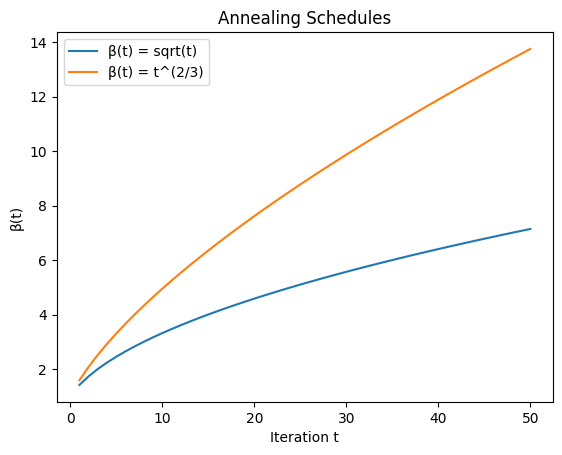

In [20]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ott.solvers.linear import sinkhorn
from ott.geometry.pointcloud import PointCloud
from ott.solvers.linear.sinkhorn import Sinkhorn
from ott.problems.linear import linear_problem
from ott.geometry import geometry
import numpy as np
from ott.geometry.costs import SqEuclidean
from ott.geometry.epsilon_scheduler import Epsilon

n, m = 50, 50
key = jax.random.PRNGKey(0)
x = jax.random.normal(key, (n, 2))
y = jax.random.normal(key, (m, 2))

p = jnp.ones(n) / n
q = jnp.ones(m) / m
geom = PointCloud(x, y)

def beta_schedule_sqrt(t):
    return 1 * (t + 1) ** (1/2)

def beta_schedule_t2_3(t):
    return 1 * (t + 1) ** (2/3)

def run_annealed_sinkhorn(beta_schedule, max_iter=50):
    beta_t = beta_schedule(jnp.arange(1, max_iter + 1))
    a, b = jnp.ones(n), jnp.ones(m)
    for t in range(max_iter):
        K = jnp.exp(-beta_t[t] * geom.cost_matrix)
        a = p / (K @ b)
        b = q / (K.T @ a)
    return a[:, None] * K * b[None, :], beta_t

pi_sqrt, beta_sqrt = run_annealed_sinkhorn(beta_schedule_sqrt)
pi_t2_3, beta_t2_3 = run_annealed_sinkhorn(beta_schedule_t2_3)
ot_problem = linear_problem.LinearProblem(geom, p, q)

solver = Sinkhorn()
sinkhorn_result = solver(ot_problem)

cost_sqrt = jnp.sum(pi_sqrt * geom.cost_matrix)
cost_t2_3 = jnp.sum(pi_t2_3 * geom.cost_matrix)
cost_sinkhorn = jnp.sum(sinkhorn_result.matrix * geom.cost_matrix)

print(f"OT cost (Sinkhorn): {cost_sinkhorn:.4f}")
print(f"OT cost (Annealed Sinkhorn - sqrt schedule): {cost_sqrt:.4f}")
print(f"OT cost (Annealed Sinkhorn - t^(2/3) schedule): {cost_t2_3:.4f}")

plt.plot(jnp.arange(1, 50 + 1), beta_sqrt, label="β(t) = sqrt(t)")
plt.plot(jnp.arange(1, 50 + 1), beta_t2_3, label="β(t) = t^(2/3)")
plt.xlabel("Iteration t")
plt.ylabel("β(t)")
plt.legend()
plt.title("Annealing Schedules")
plt.show()

Here, our beta schedulers perform as expected, being non - decreasing over time and with $𝛽_t$ - $𝛽_t-_1$ that tends to zero at infinty.

Then, we compare standard and annealed Sinkhorn on random point clouds using both geometric and unstructured costs. We track how the OT suboptimality decreases over iterations for different β values and annealing schedules ($𝜅=1/2$ and $κ=2/3$). The plots show how annealing improves convergence, especially when using debiasing.

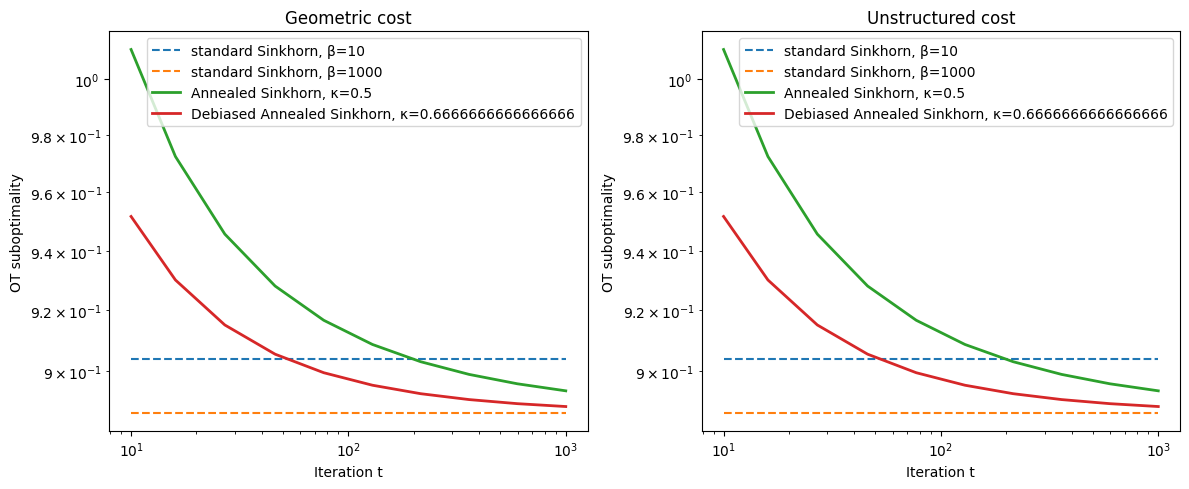

In [21]:
n = 100
d = 2
iterations = np.logspace(1, 3, num=10, dtype=int)

rng = np.random.RandomState(42)
x = rng.randn(n, d)
y = rng.randn(n, d)

geom = PointCloud(jnp.array(x), jnp.array(y), cost_fn=SqEuclidean())

p = jnp.ones(n) / n
q = jnp.ones(n) / n

beta_values = [10, 1000]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, cost_type in zip(axes, ["Geometric", "Unstructured"]):
    for beta in beta_values:
        ot_problem = linear_problem.LinearProblem(geom, p, q, tau_a=1 / beta)

        err = []

        for i in iterations:
            solver = Sinkhorn(max_iterations=i)
            sol = solver(ot_problem)
            ot_cost_unreg = jnp.sum(sol.f * p) + jnp.sum(sol.g * q)
            err.append(sol.reg_ot_cost - ot_cost_unreg)

        ax.plot(iterations, err, linestyle="dashed", label=f"standard Sinkhorn, β={beta}")

    for kappa in [1/2, 2/3]:
        annealed_err = []
        for i in iterations:
            beta_t = 10 / np.linalg.norm(x - y, ord=2) * (1 + i) ** kappa
            ot_problem = linear_problem.LinearProblem(geom, p, q, tau_a=1 / beta_t)
            solver = Sinkhorn(max_iterations=i)
            sol = solver(ot_problem)
            ot_cost_unreg = jnp.sum(sol.f * p) + jnp.sum(sol.g * q)
            annealed_err.append(sol.reg_ot_cost - ot_cost_unreg)

        label = f"Annealed Sinkhorn, κ={kappa}" if kappa == 1/2 else f"Debiased Annealed Sinkhorn, κ={kappa}"
        linestyle = "-" if kappa == 1/2 else "solid"
        ax.plot(iterations, annealed_err, linestyle=linestyle, linewidth=2, label=label)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Iteration t")
    ax.set_ylabel("OT suboptimality")
    ax.set_title(f"{cost_type} cost")
    ax.legend()

plt.tight_layout()
plt.show()


We can see that overall, the debiased method performs much better than the standard annealed Sinkhorn, which is exactly what we would expect based on the results reported in the paper. An important point to note here is that we did not yet project the resulting coupling onto a valid transport plan, and thus the computed OT suboptimality may still include some mass imbalance or numerical artifacts, as well as not directly match graphs from the paper.

In [22]:
def project_to_transport_plan(pi, p, q):
    a = jnp.minimum(1.0, p / (pi @ jnp.ones(pi.shape[1])))
    pi_prime = pi * a[:, None]

    b = jnp.minimum(1.0, q / (pi_prime.T @ jnp.ones(pi_prime.shape[0])))
    pi_dprime = pi_prime * b[None, :]

    delta_p = p - pi_dprime @ jnp.ones(pi_dprime.shape[1])
    delta_q = q - pi_dprime.T @ jnp.ones(pi_dprime.shape[0])

    norm_delta_p = jnp.sum(jnp.abs(delta_p))
    pi_proj = pi_dprime + jnp.outer(delta_p, delta_q) / norm_delta_p

    return pi_proj

The symmetric variant of the Sinkhorn algorithm is interesting because it ensures that the transport plan satisfies both marginal constraints simultaneously, addressing asymmetry issues in standard Sinkhorn outputs. This is particularly useful for symmetric problems like EOTβ(p, p) and provides a framework to compute a regularization path for unbalanced OT problems, which can be advantageous in specific applications.


In [23]:
def run_symmetric_annealed_sinkhorn(geom, p, q, beta_schedule, max_iter=100, debiased=False):
    n, m = len(p), len(q)
    a, b = jnp.ones(n), jnp.ones(m)
    a_previous, b_previous = jnp.ones(n), jnp.ones(m)

    pi_list = []
    beta_list = []
    cost_list = []
    K = jnp.exp(geom.cost_matrix)

    for t in range(1, max_iter + 1):
        beta_t = beta_schedule(t)


        if debiased and t > 1:
            debias_p = a ** (0.5 + (1 - jnp.maximum(beta_schedule(t-2),0)/beta_schedule(t-1)))
            debias_q = b ** (0.5 + (1 - jnp.maximum(beta_schedule(t-2),0)/beta_schedule(t-1)))
            a = debias_p * (p / (K @ b_previous)) ** 0.5
            b = debias_q * (q / (K.T @ a_previous)) ** 0.5
        else:
            a = (a * (p / (K @ b_previous))) ** 0.5
            b = (b * (q / (K.T @ a_previous))) ** 0.5

        K = jnp.exp(-beta_t * geom.cost_matrix)

        pi_t = a[:, None] * K * b[None, :]
        pi_t = pi_t / jnp.sum(pi_t)
        pi_proj = project_to_transport_plan(pi_t, p, q)
        cost = jnp.sum(pi_proj * geom.cost_matrix)
        pi_list.append(pi_proj)
        beta_list.append(beta_t)
        cost_list.append(cost)
        a_previous, b_previous = a, b

    return pi_list, beta_list, cost_list

We also notice that it lends in less suboptimality when debiasing the symmetric sinkorn.

{'costs': [Array(3.4943202, dtype=float32), Array(2.9247105, dtype=float32), Array(1.7998307, dtype=float32), Array(1.5395969, dtype=float32), Array(1.4430649, dtype=float32), Array(1.3847102, dtype=float32), Array(1.3415654, dtype=float32), Array(1.3070213, dtype=float32), Array(1.2781452, dtype=float32), Array(1.2532244, dtype=float32), Array(1.2313397, dtype=float32), Array(1.2120517, dtype=float32), Array(1.1949991, dtype=float32), Array(1.1796212, dtype=float32), Array(1.165631, dtype=float32), Array(1.1528224, dtype=float32), Array(1.1410388, dtype=float32), Array(1.1304235, dtype=float32), Array(1.1206148, dtype=float32), Array(1.1114519, dtype=float32), Array(1.1028558, dtype=float32), Array(1.0947753, dtype=float32), Array(1.0871551, dtype=float32), Array(1.0799534, dtype=float32), Array(1.0731288, dtype=float32), Array(1.0666472, dtype=float32), Array(1.06048, dtype=float32), Array(1.0545995, dtype=float32), Array(1.0489835, dtype=float32), Array(1.0436102, dtype=float32), Ar

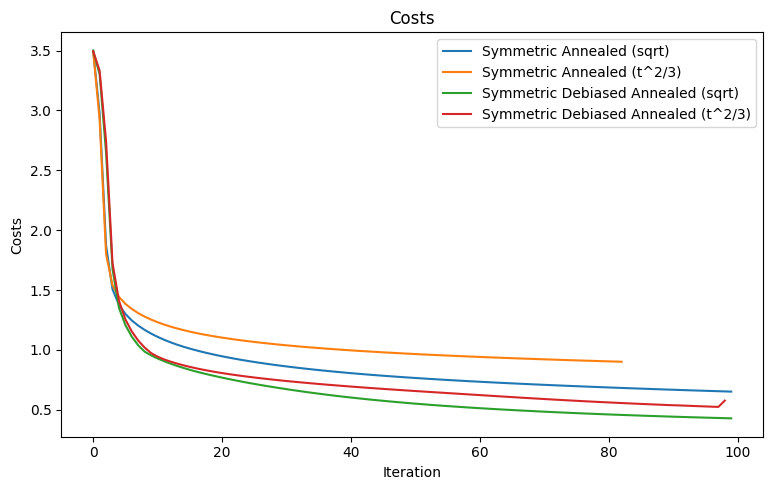

In [24]:

max_iter = 100
methods = {
    "Symmetric Annealed (sqrt)": (run_symmetric_annealed_sinkhorn, beta_schedule_sqrt, False),
    "Symmetric Annealed (t^2/3)": (run_symmetric_annealed_sinkhorn, beta_schedule_t2_3, False),
    "Symmetric Debiased Annealed (sqrt)": (run_symmetric_annealed_sinkhorn, beta_schedule_sqrt, True),
    "Symmetric Debiased Annealed (t^2/3)": (run_symmetric_annealed_sinkhorn, beta_schedule_t2_3, True),
}

results = {}
for name, (func, schedule, debiased) in methods.items():
    pi_list, beta_list, cost_list = func(geom, p, q, schedule, max_iter, debiased)
    results[name] = {
        "costs": cost_list,
        "betas": beta_list
    }
print(results["Symmetric Annealed (t^2/3)"])
print(results["Symmetric Debiased Annealed (t^2/3)"])

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for name, data in results.items():
    plt.plot(data["costs"], label=name)
plt.xlabel('Iteration')
plt.ylabel('Costs')
plt.title('Costs')
plt.legend()

plt.tight_layout()
plt.show()

We then implemented the non-symmetric Annealed Sinkhorn algorithm (Algorithm 3 from the paper), with optional debiasing. Here, at each iteration, it updates the kernel matrix using the current $β_t$, performs asymmetric Sinkhorn updates on the scaling factors, and optionally applies a debiasing correction to the marginals. The transport plan is normalized and projected to match the marginals, and its cost is recorded. The function returns the full sequence of transport plans, $β_t$ values, and OT costs across iterations.

In [25]:
def run_annealed_sinkhorn(geom, p, q, beta_schedule, max_iter=100, debiased=False):
    a, b = p.copy(),q.copy()

    pi_list = []
    beta_list = []
    cost_list = []

    for t in range(1, max_iter + 1):
        beta_t = max(beta_schedule(t),1e-6)
        K = jnp.exp(geom.cost_matrix)
        temp=1
        if debiased and t > 1:
            gamma = max(beta_schedule(t-2),0) / beta_schedule(t-1)
            temp = a ** (1 - gamma)
        a = temp * p / (K @ b)
        K = jnp.exp(-beta_t * geom.cost_matrix)
        b = q / (K.T @ a)

        pi_t = a[:, None] * K * b[None, :]
        pi_t = pi_t / jnp.sum(pi_t)
        pi_proj = project_to_transport_plan(pi_t, p, q)
        cost = jnp.sum(pi_proj * geom.cost_matrix)

        pi_list.append(pi_proj)
        beta_list.append(beta_t)
        cost_list.append(cost)

    return pi_list, beta_list, cost_list

In this section, we tried to recreate the first part of the second figure of the paper, by generating a synthetic 1D histograms with random weights and evaluate the performance of Annealed Sinkhorn and Debiased Annealed Sinkhorn across a range of annealing exponents $κ$. For each $κ$, we run both methods over 200 iterations and measure the OT suboptimality relative to the true OT cost. We then plot the final errors to identify which annealing schedule achieves the best accuracy.

It is important to note that despite the paper showing that the debiased method should not perform worse than the standard annealed version, our methods were not able to match this result. Our graphs were very unstable, largely due to the presence of NaN values during the iterations, which caused irregularities in the convergence process. These instabilities made it difficult to fully resolve the issue. As a potential approach to mitigate this, transforming the computations into sums of logarithms would offer a more stable numerical approach and help avoid issues caused by small or zero values during the optimization. We were unable to fully resolve this problem, and we thus decided for the next part to examine the code that was given inside the research paper to recreate the function.

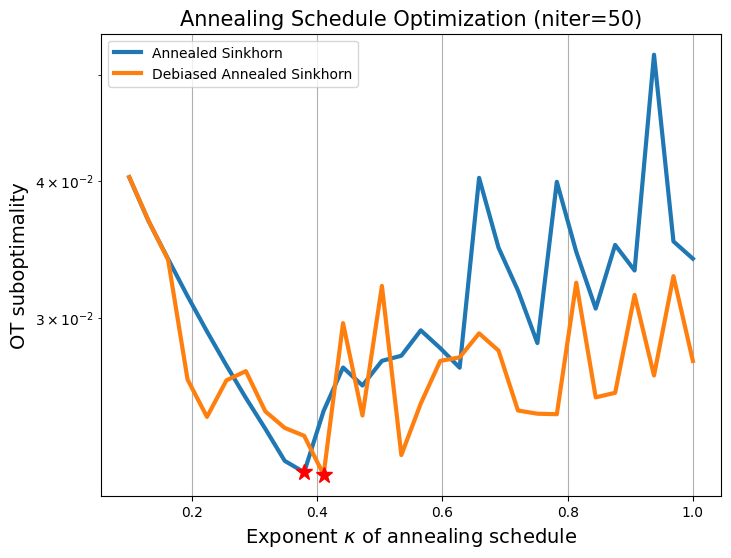

In [26]:
n = 20
key = jax.random.PRNGKey(42)
a = jax.random.uniform(key, shape=(n,))
a = a / jnp.sum(a)
b = jax.random.uniform(key + 1, shape=(n,))
b = b / jnp.sum(b)

x = jnp.arange(n).reshape(-1, 1)
y = jnp.arange(n).reshape(1, -1)
cost_matrix = (x - y) ** 2
cost_matrix = cost_matrix / jnp.max(cost_matrix)

geom_true = geometry.Geometry(cost_matrix=cost_matrix, epsilon=1e-6)
problem_true = linear_problem.LinearProblem(geom_true, a=a, b=b)
solver = sinkhorn.Sinkhorn()
out_true = solver(problem_true)
true_ot = out_true.reg_ot_cost

niter = 50
cost_osc = jnp.max(cost_matrix) - jnp.min(cost_matrix)
beta0 = 10.0 / cost_osc
kappas = np.linspace(0.1, 1.0, 30)

err_tab1 = np.zeros(len(kappas))
err_tab2 = np.zeros(len(kappas))

for idx, kappa in enumerate(kappas):
    beta_schedule = lambda t: beta0 * (1 + t) ** (kappa)
    geom = geometry.Geometry(cost_matrix=cost_matrix)

    _, _, cost_list = run_annealed_sinkhorn(geom, a, b, beta_schedule, max_iter=niter, debiased=False)
    errors = jnp.array(cost_list) - true_ot
    err_tab1[idx] = errors[~jnp.isnan(errors)][-1]

    _, _, cost_list = run_annealed_sinkhorn(geom, a, b, beta_schedule, max_iter=niter, debiased=True)
    errors = jnp.array(cost_list) - true_ot
    err_tab2[idx] = errors[~jnp.isnan(errors)][-1]

plt.figure(figsize=(8,6))
plt.semilogy(kappas, err_tab1, label='Annealed Sinkhorn', lw=3)
plt.semilogy(kappas, err_tab2, label='Debiased Annealed Sinkhorn', lw=3)

I1 = np.argmin(err_tab1)
I2 = np.argmin(err_tab2)

plt.plot(kappas[I1], err_tab1[I1], 'r*', ms=12)
plt.plot(kappas[I2], err_tab2[I2], 'r*', ms=12)

plt.xlabel(r'Exponent $\kappa$ of annealing schedule', fontsize=14)
plt.ylabel(r'OT suboptimality', fontsize=14)
plt.legend()
plt.grid(True)
plt.title(f'Annealing Schedule Optimization (niter={niter})', fontsize=15)
plt.show()


After encountering difficulties in reproducing the debiased results in the 1D histogram setting, we turned to the code provided in the research paper to guide the next phase of our experiments, as well as to reimplement the algorithm. In this part, we adapted their approach to work on synthetic 2D point clouds. We generated two distinct point clouds and evaluated both Annealed Sinkhorn and Debiased Annealed Sinkhorn across a range of annealing exponents κ.

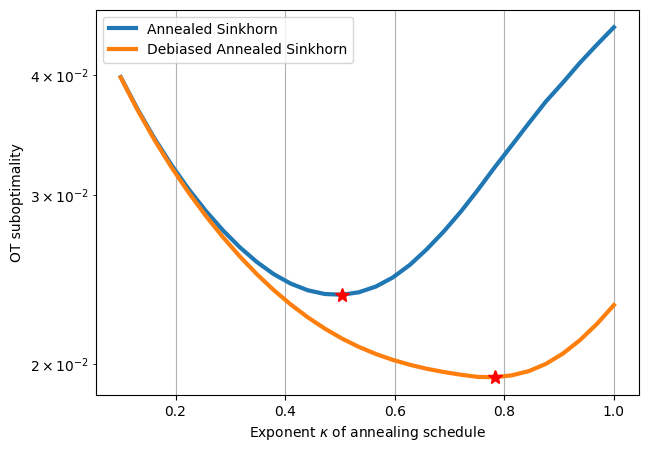

In [27]:
def sinkhorn_track(p, q, c, niter=100, ot_cost=0.0, kappa=0.0, beta0=1.0, debiased=True):
    m, n = p.shape[0], q.shape[0]
    u, v = jnp.zeros(m), jnp.zeros(n)
    lp, lq = jnp.log(p), jnp.log(q)
    err = []
    beta = beta0
    gamma = jnp.exp(u[:, None] + lp[:, None] + v[None, :] + lq[None, :] - beta * c)
    for t in range(1, niter + 1):
        if debiased:
            temp1 = lq + v - beta * c - ((t ** kappa - (t - 1) ** kappa) / t ** kappa) * u[:, None]
        else:
            temp1 = v + lq - beta * c
        stab1 = jnp.max(temp1, axis=1, keepdims=True)
        u = -stab1.squeeze() - jnp.log(jnp.sum(jnp.exp(temp1 - stab1), axis=1))
        if t % max(int(jnp.floor(jnp.sqrt(t))), 1) == 0:
            beta = beta0 * (t + 1) ** kappa
        temp2 = u[:, None] + lp[:, None] - beta * c
        stab2 = jnp.max(temp2, axis=0, keepdims=True)
        v = -stab2.squeeze() - jnp.log(jnp.sum(jnp.exp(temp2 - stab2), axis=0))
        gamma = jnp.exp(u[:, None] + lp[:, None] + v[None, :] + lq[None, :] - beta * c)
        proj_gamma = project_to_transport_plan(gamma, p, q)
        err.append(jnp.sum(c * proj_gamma) - ot_cost)
    return gamma, jnp.array(err)

key = jax.random.PRNGKey(1)
m, n = 150, 150
ang1 = jax.random.uniform(key, shape=(m,)) * jnp.pi
rad1 = jax.random.uniform(key, shape=(m,)) * 0.2 + 0.3
X1 = jnp.stack([rad1 * jnp.cos(ang1), rad1 * jnp.sin(ang1)], axis=1)
ang2 = jax.random.uniform(key, shape=(m,)) * 2 * jnp.pi
rad2 = jax.random.uniform(key, shape=(m,)) * 0.1
X2 = jnp.stack([rad2 * jnp.cos(ang2) - 0.3, rad2 * jnp.sin(ang2) + 0.4], axis=1)
X = jnp.concatenate([X1, X2], axis=0)
Y1 = jnp.stack([jax.random.uniform(key, shape=(n,)) - 0.5, jax.random.uniform(key, shape=(n,)) * 0.15], axis=1)
Y2 = jnp.stack([(jax.random.uniform(key, shape=(n,)) - 0.5) * 0.15, jax.random.uniform(key, shape=(n,)) * 0.6], axis=1)
Y = jnp.concatenate([Y1, Y2], axis=0)
p = jnp.ones(X.shape[0]) / X.shape[0]
q = jnp.ones(Y.shape[0]) / Y.shape[0]
geom_true = PointCloud(X, Y, epsilon=1e-6)
problem_true = linear_problem.LinearProblem(geom_true, a=p, b=q)
solver = sinkhorn.Sinkhorn()
out_true = solver(problem_true)
ot_cost = out_true.reg_ot_cost

niter = 200
beta0 = 10
kappas = np.linspace(0.1, 1.0, 30)
err_tab1 = np.zeros(len(kappas))
err_tab2 = np.zeros(len(kappas))

for i, kappa in enumerate(kappas):
    _, err1 = sinkhorn_track(p, q, geom_true.cost_matrix, niter=niter, ot_cost=ot_cost, kappa=kappa, beta0=beta0, debiased=False)
    err_tab1[i] = err1[-1]
    _, err2 = sinkhorn_track(p, q, geom_true.cost_matrix, niter=niter, ot_cost=ot_cost, kappa=kappa, beta0=beta0, debiased=True)
    err_tab2[i] = err2[-1]

plt.figure(figsize=(7, 5))
plt.semilogy(kappas, err_tab1, label='Annealed Sinkhorn', lw=3)
plt.semilogy(kappas, err_tab2, label='Debiased Annealed Sinkhorn', lw=3)
plt.xlabel(r'Exponent $\kappa$ of annealing schedule')
plt.ylabel(r'OT suboptimality')
plt.legend()
plt.grid(True)

i1 = np.argmin(err_tab1)
i2 = np.argmin(err_tab2)
plt.plot(kappas[i1], err_tab1[i1], 'r*', ms=10)
plt.plot(kappas[i2], err_tab2[i2], 'r*', ms=10)
plt.show()

Finally, to complement the paper's implementation, we also integrated the Epsilon scheduler from the OTT JAX library to compare it against the Annealed Sinkhorn and Debiased Annealed Sinkhorn methods. In this part, we ran all three approaches over synthetic 2D point clouds, sweeping over different annealing exponents κ. Our goal was to evaluate whether the built-in scheduling in OTT JAX could match or outperform the custom annealing schedules, and to analyze how the choice of scheduler affects OT suboptimality across iterations.

We did not manage to get ott's geometry epsilon_scheduler to work as it has some wierd interactions between initial vaule and target. This seems to be a known issue as  mentionned in https://github.com/ott-jax/ott/issues/478. So we had to re implement the scheduler ourselfs, then inject it into the jax framework. We also noticed that ott's regularisation scheduler follows init * decay ^ it, while the paper's implementation suggests init * (1 + it) ** decay. for more fildelity to the task of comparing the jax libriray, we reimplmented the scheduler the way jax does it.

Epsilon(target=1.3493, init=10.0000, decay=0.1000)
Iteration 0: epsilon=10.0, transport mass=0.9999997615814209, cost=0.19387459754943848
Iteration 1: epsilon=1.0, transport mass=0.9999997019767761, cost=0.18873518705368042
Iteration 2: epsilon=0.10000000000000002, transport mass=0.9999997615814209, cost=0.14773410558700562
Iteration 3: epsilon=0.010000000000000002, transport mass=1.0, cost=0.09782948344945908
Iteration 4: epsilon=0.0010000000000000002, transport mass=0.9999997615814209, cost=0.08469340950250626
Iteration 5: epsilon=0.00010000000000000002, transport mass=1.0000028610229492, cost=0.08243555575609207
Iteration 6: epsilon=1.0000000000000004e-05, transport mass=1.0001049041748047, cost=0.08211793005466461
Iteration 7: epsilon=1.0000000000000004e-06, transport mass=0.9981322884559631, cost=0.08207801729440689
Iteration 8: epsilon=1e-06, transport mass=0.9984339475631714, cost=0.0820780023932457
Iteration 9: epsilon=1e-06, transport mass=0.9985767602920532, cost=0.0820780172

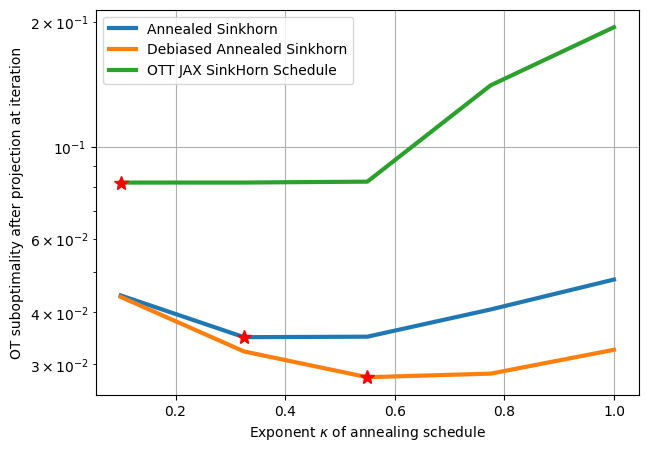

In [28]:
from ott.geometry.epsilon_scheduler import Epsilon
def beta_schedule_jax_comparaison(t, init=1, decay=5/6):
    return init*(decay**t)

def solve_ot_with_scheduler(x, y, a, b, target_epsilon=0.1, init=2.0, decay=0.95, num_iterations=10, cost_matrix=None):
    scheduler = Epsilon(target=jnp.array(target_epsilon), init=init, decay=decay)
    print(scheduler)
    solver = sinkhorn.Sinkhorn()
    out = None
    hist=[]
    for it in range(num_iterations):
        eps = max(scheduler(it), 1e-6)
        eps = max(beta_schedule_jax_comparaison(it, init=init, decay=decay),1e-6)
        geom = geometry.Geometry(cost_matrix=cost_matrix, epsilon=eps)
        problem = linear_problem.LinearProblem(geom, a=a, b=b)
        init_potentials = (out.f, out.g) if out is not None else  None
        out = solver(problem, init=init_potentials)

        hist.append(out.reg_ot_cost)
        print(f"Iteration {it}: epsilon={eps}, transport mass={out.transport_mass}, cost={out.reg_ot_cost}")

    return hist

key = jax.random.PRNGKey(1)
m, n = 150, 150
ang1 = jax.random.uniform(key, shape=(m,)) * jnp.pi
rad1 = jax.random.uniform(key, shape=(m,)) * 0.2 + 0.3
X1 = jnp.stack([rad1 * jnp.cos(ang1), rad1 * jnp.sin(ang1)], axis=1)
ang2 = jax.random.uniform(key, shape=(m,)) * 2 * jnp.pi
rad2 = jax.random.uniform(key, shape=(m,)) * 0.1
X2 = jnp.stack([rad2 * jnp.cos(ang2) - 0.3, rad2 * jnp.sin(ang2) + 0.4], axis=1)
X = jnp.concatenate([X1, X2], axis=0)
Y1 = jnp.stack([jax.random.uniform(key, shape=(n,)) - 0.5, jax.random.uniform(key, shape=(n,)) * 0.15], axis=1)
Y2 = jnp.stack([(jax.random.uniform(key, shape=(n,)) - 0.5) * 0.15, jax.random.uniform(key, shape=(n,)) * 0.6], axis=1)
Y = jnp.concatenate([Y1, Y2], axis=0)
p = jnp.ones(X.shape[0]) / X.shape[0]
q = jnp.ones(Y.shape[0]) / Y.shape[0]
cost_matrix = jnp.sum((X[:, None, :] - Y[None, :, :]) ** 2, axis=2)
cost_matrix = cost_matrix / (jnp.max(cost_matrix) - jnp.min(cost_matrix))
geom_true = PointCloud(X, Y, epsilon=1e-6)
problem_true = linear_problem.LinearProblem(geom_true, a=p, b=q)
solver = sinkhorn.Sinkhorn()
out_true = solver(problem_true)
ot_cost = out_true.reg_ot_cost

niter = 20
beta0 = 10
kappas = np.linspace(0.1, 1.0, 5)
err_tab1 = np.zeros(len(kappas))
err_tab2 = np.zeros(len(kappas))
err_tab3 = np.zeros(len(kappas))

for i, kappa in enumerate(kappas):
    _, err1 = sinkhorn_track(p, q, cost_matrix, niter=niter, ot_cost=ot_cost, kappa=kappa, beta0=beta0, debiased=False)
    err_tab1[i] = err1[-1]
    _, err2 = sinkhorn_track(p, q, cost_matrix, niter=niter, ot_cost=ot_cost, kappa=kappa, beta0=beta0, debiased=True)
    err_tab2[i] = err2[-1]
    err3 = solve_ot_with_scheduler(
        X, Y ,p, q, target_epsilon=niter ** kappa, init=beta0, decay=kappa, num_iterations=niter, cost_matrix=cost_matrix
)
    err_tab3[i] = err3[-1]

plt.figure(figsize=(7, 5))
plt.semilogy(kappas, err_tab1, label='Annealed Sinkhorn', lw=3)
plt.semilogy(kappas, err_tab2, label='Debiased Annealed Sinkhorn', lw=3)
plt.semilogy(kappas, err_tab3, label='OTT JAX SinkHorn Schedule', lw=3)
plt.xlabel(r'Exponent $\kappa$ of annealing schedule')
plt.ylabel(r'OT suboptimality after projection at iteration')
plt.legend()
plt.grid(True)

i1 = np.argmin(err_tab1)
i2 = np.argmin(err_tab2)
i3 = np.argmin(err_tab3)
plt.plot(kappas[i1], err_tab1[i1], 'r*', ms=10)
plt.plot(kappas[i2], err_tab2[i2], 'r*', ms=10)
plt.plot(kappas[i3], err_tab3[i3], 'r*', ms=10)
plt.show()

Our results suggest that the debiased annealed methods continue to offer superior robustness and effectiveness in terms of convergence and minimizing optimal transport suboptimality. On the other hand, the OTT JAX method showed some signs of stagnation and gradual degradation over iterations. This might be due to limitations in our specific implementation, and it's possible that further refinements in the method's configuration could improve its performance. While classic annealed methods remain reliable for OT problems, the OTT JAX approach could still hold promise with additional tuning and optimizations.